# Spectral analysis of time series

This lab will examine a few different time series:
1. Mona Loa atmospheric $CO_2$ concentrations spanning ~62 years (at monthly intervals, [Keeling et al., 2001](https://escholarship.org/uc/item/09v319r9)).
2. Ocean sediment core $\delta^{18}O$ spanning ~65 million years (at 3000 year intervals, [Westerhold et al. 2020](https://science.sciencemag.org/content/369/6509/1383)),
3. (**Optional**) Greenland ice sheet $\delta^{18}O$ spanning ~100 thousand years (at 50 year intervals, [NGRIP team, 2004](https://epic.awi.de/id/eprint/10226/1/Nor2004a.pdf)), and
4. (**Optional**) Dow Jones Industrial Average spanning ~35 years (at daily intervals, [Yahoo Finance, 2020](https://finance.yahoo.com/quote/%5EDJI)). 

All of these time series have different variability at differrent frequencies.  As you explore the power at each frequency of each time series, the analysis is limited by two key features of each time series:
1. length and
2. sampling interval.

The length of the time series sets the maximum wavelength (lowest frequency) of a signal that can be searched for in the data.  The sampling interval sets the smallest wavelength (highest frequency) that can be identified.  Any frequencies greater than half of the sampling frequency (i.e. twice the time intervals at which the data are presented since $f = 1/T$, where $f$ is frequency and $T$ is the period) cannot be properly represented.  This critical frequency is called the Nyquist frequency.

The `ft` function below is used to break up the input time series into a sum of sines and cosines, each wave has its own amplitude and frequency.  Key elements of the original signal can be reconstructed when the most important (i.e. highest energy) waveforms are added back together again.

# Procedure

1. Read and run the code that creates the plots in Part 1.  This part is a spectral analysis of the time series of atmospheric $CO_2$.
2. Repeat the steps for Part 2 but for the ocean $\delta^{18}O$ time series.  In this case, build a reconstructed time series from the 23ky, 40ky, 100ky, and 400ky bands.
3. **Optional:**  Repeat step 1 for the NGRIP and DJIA time series, if you're curious.
4. Answer the discussion questions at the end.


In [111]:
#==================================
# Setup access to tools
#==================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#==================================
# Load the data 
#==================================

# Sediment core d18O
d18o_oce_data = np.loadtxt(
    "/mnt/courses/eos2585/CENOGRID/Westerhold_etal_20_data.xyz",
    comments="#",
    delimiter=" ",
    unpack=False)
d18o_oce = d18o_oce_data[:,1]
d18o_oce_time = d18o_oce_data[:,0]

# Ice core d18O
d18o_ice_data = np.loadtxt('/mnt/courses/eos2585/NGRIP/ngrip-d18o-50yr.xyz')
d18o_ice = d18o_ice_data[:,1]
d18o_ice_time = d18o_ice_data[:,0]

# DJIA data
djia_data = np.loadtxt(
    "/mnt/courses/eos2585/YAHOO_finance/DJIA_1985to2020.xyz",
    comments="#",
    delimiter=",",
    unpack=False)
djia_year = djia_data[:,0]
djia_month = djia_data[:,1]
djia_day = djia_data[:,2]
djia = djia_data[:,7]
# Combine year, month, day into a single "decimal year" number for the date.
djia_time = djia_year + djia_month/12 - 1 + djia_day/365

# Atm. CO2 data
co2_data = np.loadtxt("/mnt/courses/eos2585/SIO_CO2/mlo.csv",
    comments="D",
    delimiter=",",
    unpack=False)
co2 = co2_data[:,1]
co2_time = co2_data[:,0]

# USGS stream stage data
usgs_df = pd.read_csv("./USGS_data.txt",
        delim_whitespace=True,
        comment="#",
        header=1,                         
        skiprows=1,
        usecols=[2,3,5],
        names=["yyyy-mm-dd","hh:mm","data"],
        parse_dates=[["yyyy-mm-dd","hh:mm"]])

# Thanks to Chris35Wills, http://chris35wills.github.io/time_elapsed_pandas/
position = usgs_df.columns.get_loc('yyyy-mm-dd_hh:mm')
usgs_df['elapsed'] =  usgs_df.iloc[1:, position] - usgs_df.iat[0, position]
usgs_df['elapsed_seconds'] = usgs_df.elapsed.dt.total_seconds()

usgs_time = np.array(usgs_df['elapsed_seconds'])
usgs_time[0] = 0
usgs_data = np.array(usgs_df['data'])

In [89]:
#--------------------------------------------------------------------------
# Based on the numpy.linalg.lstsq documentation
# at: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
# this function computes the slope and intercept
# of the line of best fit.
#--------------------------------------------------------------------------
def find_slope_intercept(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

In [90]:
#--------------------------------------------------------------------------
# Find the index in an array given an approximate value (the closest value)
#--------------------------------------------------------------------------
def find_approx_index(x,v):
    # Compute the absolute value of the difference
    # between each element in the input array, x,
    # and the value we seek, v.  The smallest value
    # is the closest value to the value we seek.
    abs_diff = np.abs(x-v)
    
    # Return the location of the smallest absolute
    # difference.
    return np.where(abs_diff == np.min(abs_diff))

In [91]:
#--------------------------------------------------------------------------
# Compute the (slow) Fourier transform of the INput SIGnal (insig) with
# the number of basis functions nbasis.  Also required is the time
# axis defining the points of the signal.  Outputs are:
# f = frequency corresponding to each basis function [Hz]
# w = angular freq. corresponding to each basis function [rad/s]
# a = coefficients for the cosines [units of input signal]
# b = coefficients for the sines [units of input signal]
# They are returned as a list for iterable unpacking, e.g.
# f,w,a,b = ft(t,s,n)
#
# Stefan Gary, Feb. 2009, translated to Python Nov. 2020.
#--------------------------------------------------------------------------
def ft(t_axis,insig,nbasis):

    # Compute the period from the given time axis
    T = np.max(t_axis)-np.min(t_axis);

    # Allocate memory for the output
    a = np.zeros(nbasis);  # Coefficients for the cosines
    b = np.zeros(nbasis);  # Coefficients for the sines
    w = np.zeros(nbasis);  # Angular frequency
    f = np.zeros(nbasis);  # Regular frequency

    # Compute the coefficients for each basis function
    # using the explicit orthogonality condition (direct
    # integration).
    #
    # Loop starts with q = 1 -> lowest frequency with period length of signal
    # More basis functions will go to higher and higher frequencies.
    for q in range(nbasis):
        #print('For basis function number---'+str(q))
        f[q] = (q+1)/T
        w[q] = 2*np.pi*f[q]
        a[q] = (2/T)*np.trapz(insig*np.cos(w[q]*t_axis),t_axis)
        b[q] = (2/T)*np.trapz(insig*np.sin(w[q]*t_axis),t_axis);                     

    return [f,w,a,b]

# Part 1: $CO_2$ time series as a first example

The $CO_2$ time series is a great starting point because it has:
1. clear seasonality and a
2. clear long-term trend.

Both of these features are immediately visible by eye.  The next
block of code steps through the process of detrending, finding
the power of each frequency in the signal, and then plotting:
1. the original signal,
2. the spectrum, and the
3. signal at just one frequency (the annual cycle).

[Text(0.5, 1.0, 'Seasonal cycle at [0.99461624] cycle/year'),
 Text(0.5, 0, 'Time, t [years]'),
 Text(0, 0.5, 'CO2 [ppm]')]

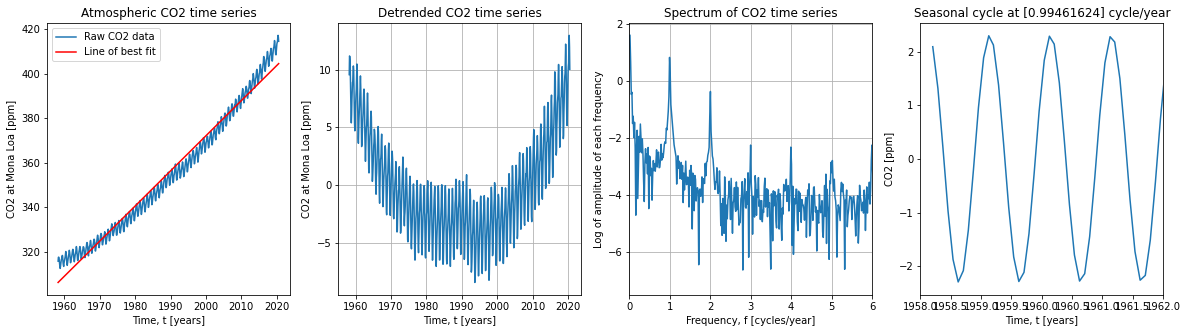

In [92]:
# Detrend
slope,intercept = find_slope_intercept(co2_time,co2)
co2_detrend = co2 - co2_time*slope - intercept

# Find power at each frequency
# The (slow) Fourier transform function
# used here is much simpler and slower than the
# fast Fourier transform (FFT) built into numpy.
# An example for using the FFT is below.
f,w,a,b = ft(co2_time,co2_detrend,1000)

# power = np.abs(np.fft.rfft(co2_detrend))

#-------------------------------------
# Plots!
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,5))
ax0.plot(co2_time,co2)
ax0.plot(co2_time,co2_time*slope+intercept,'red')
ax0.legend(("Raw CO2 data","Line of best fit"))
ax0.set(
    title="Atmospheric CO2 time series",
    xlabel="Time, t [years]",
    ylabel="CO2 at Mona Loa [ppm]")

ax1.plot(co2_time,co2_detrend)
ax1.set(
    title="Detrended CO2 time series",
    xlabel="Time, t [years]",
    ylabel="CO2 at Mona Loa [ppm]")
ax1.grid()

ax2.plot(f,np.log(np.sqrt(a**2+b**2)))
ax2.set_xlim(0,6)
ax2.set(
    title="Spectrum of CO2 time series",
    xlabel="Frequency, f [cycles/year]",
    ylabel="Log of amplitude of each frequency")
ax2.grid()

# Recreate the signal and plot
# One could search for the index of f[] manually for frequency of 1 cycle/year.
# This handy function automates the search!  Test for yourself that it's
# finding the closest value.
q = find_approx_index(f,1.0)
ax3.plot(co2_time,a[q]*np.cos(w[q]*co2_time)+b[q]*np.sin(w[q]*co2_time))
ax3.set_xlim(1958,1962)
ax3.set(
    title="Seasonal cycle at "+str(f[q])+" cycle/year",
    xlabel="Time, t [years]",
    ylabel="CO2 [ppm]")

# Part 2: Paleoclimate record

Based on Hays et al. (1976) we expect to find 23,000 year, 40,000 year, and 100,000 year peaks in the Westerhold et al. (2020) $\delta^{18}O$ benthic foraminifer time series. Because the Westerhold et al. (2020) time series is much longer than the ~500,000 year time series in Hays et al. (1976), we can also search for the 400,000 year eccentricity component. These two papers both used ocean $\delta^{18}O$ and these robust signals should be present over the global ocean.  Repeat the spectral analysis of Part 1 using the Westerhold et al. (2020) data.

Use about 3000 basis functions; the more basis functions you use, the higher the frequency that's resolved relative to the total length of the dataset.  Since the Westerhold et al. (2020) data set has many more points in it than the Keeling et al. (2001) $CO_2$ time series, you need greater temporal resolution here in Part 2 than in Part 1.

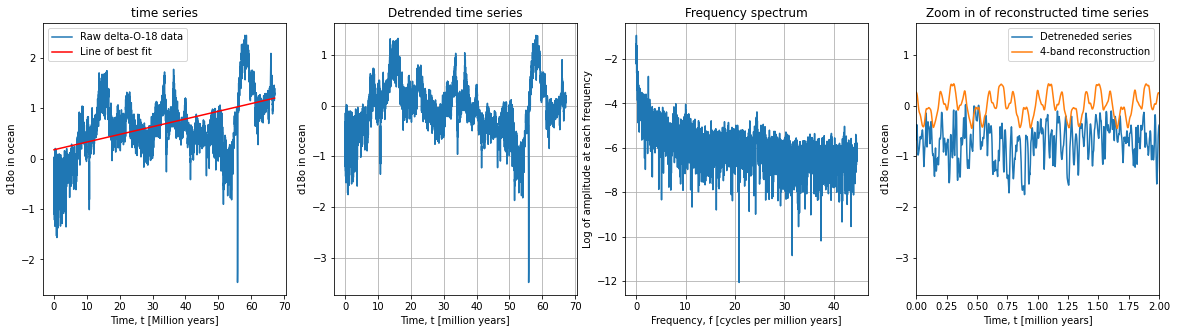

In [93]:
# Detrend
slope,intercept = find_slope_intercept(d18o_oce_time,d18o_oce)
d18o_oce_detrend = d18o_oce - d18o_oce_time*slope - intercept

# Find power at each frequency
# With the really long time series, you can really
# see the performance gain with FFT versus slow FT.
f,w,a,b = ft(d18o_oce_time,d18o_oce_detrend,3000)

# Reconstruct signal with only 4 frequency bands:
# 400,000ky, 100,000ky, 40,000ky, and 23,000ky.
# Get the index of f[] for each of the 4 frequencies:
f_400ky = 1e6/400000.0
f_100ky = 1e6/100000.0
f_040ky = 1e6/40000.0
f_023ky = 1e6/23000.0
q_400ky = find_approx_index(f,f_400ky)
q_100ky = find_approx_index(f,f_100ky)
q_040ky = find_approx_index(f,f_040ky)
q_023ky = find_approx_index(f,f_023ky)

d18o_oce_4bands = \
    a[q_400ky]*np.cos(w[q_400ky]*d18o_oce_time)+\
    b[q_400ky]*np.sin(w[q_400ky]*d18o_oce_time)+\
    a[q_100ky]*np.cos(w[q_100ky]*d18o_oce_time)+\
    b[q_100ky]*np.sin(w[q_100ky]*d18o_oce_time)+\
    a[q_040ky]*np.cos(w[q_040ky]*d18o_oce_time)+\
    b[q_040ky]*np.sin(w[q_040ky]*d18o_oce_time)+\
    a[q_023ky]*np.cos(w[q_023ky]*d18o_oce_time)+\
    b[q_023ky]*np.sin(w[q_023ky]*d18o_oce_time)

#-------------------------------------
# Plots!
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,5))
ax0.plot(d18o_oce_time,d18o_oce)
ax0.plot(d18o_oce_time,d18o_oce_time*slope+intercept,'red')
ax0.legend(("Raw delta-O-18 data","Line of best fit"))
ax0.set(
    title="time series",
    xlabel="Time, t [Million years]",
    ylabel="d18o in ocean")

ax1.plot(d18o_oce_time,d18o_oce_detrend)
ax1.set(
    title="Detrended time series",
    xlabel="Time, t [million years]",
    ylabel="d18o in ocean")
ax1.grid()

ax2.plot(f,np.log(np.sqrt(a**2+b**2)))
ax2.set(
    title="Frequency spectrum",
    xlabel="Frequency, f [cycles per million years]",
    ylabel="Log of amplitude at each frequency")
ax2.grid()

# Recreate the signal and plot
ax3.plot(d18o_oce_time,d18o_oce_detrend)
ax3.plot(d18o_oce_time,20*d18o_oce_4bands)
ax3.set_xlim(0,2)
ax3.set(
    title="Zoom in of reconstructed time series",
    xlabel="Time, t [million years]",
    ylabel="d18o in ocean")
ax3.legend(("Detreneded series","4-band reconstruction"))

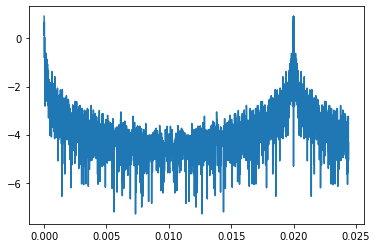

In [94]:
# Example code for NGRIP time series
slope,intercept = find_slope_intercept(d18o_ice_time,d18o_ice)
d18o_ice_detrend = d18o_ice - d18o_ice_time*slope - intercept
f,w,a,b =  ft(d18o_ice_time,d18o_ice_detrend,3000)
fig, ax = plt.subplots()
ax.plot(f,np.log(np.sqrt(a**2+b**2)))

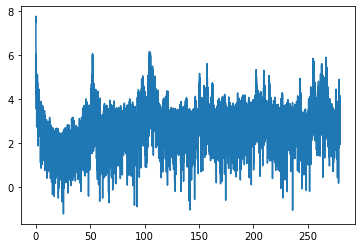

In [95]:
# Example code for DJIA time series
slope,intercept = find_slope_intercept(djia_time,djia)
djia_detrend = djia - djia_time*slope - intercept
f,w,a,b =  ft(djia_time,djia_detrend,10000)
fig, ax = plt.subplots()
ax.plot(f,np.log(np.sqrt(a**2+b**2)))

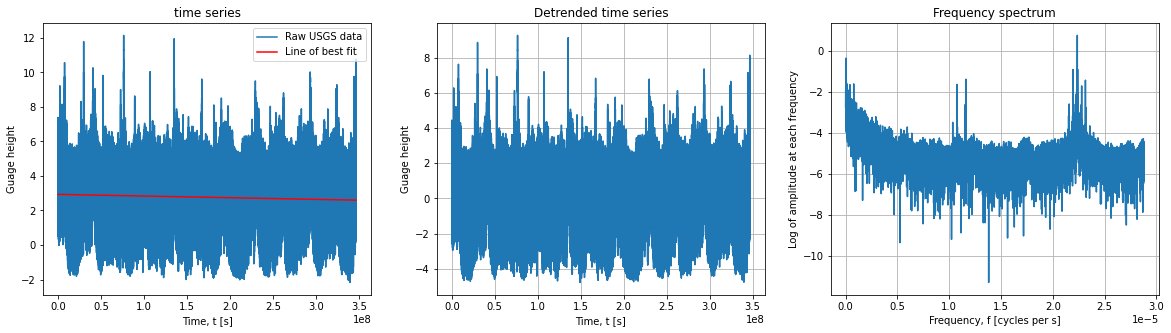

In [113]:
# Example code for USGS stream guage data
slope,intercept = find_slope_intercept(usgs_time,usgs_data)
usgs_detrend = usgs_data - usgs_time*slope - intercept
f,w,a,b =  ft(usgs_time,usgs_detrend,10000)

fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(20,5))
ax0.plot(usgs_time,usgs_data)
ax0.plot(usgs_time,usgs_time*slope+intercept,'red')
ax0.legend(("Raw USGS data","Line of best fit"))
ax0.set(
    title="time series",
    xlabel="Time, t [s]",
    ylabel="Guage height")

ax1.plot(usgs_time,usgs_detrend)
ax1.set(
    title="Detrended time series",
    xlabel="Time, t [s]",
    ylabel="Guage height")
ax1.grid()

ax2.plot(f,np.log(np.sqrt(a**2+b**2)))
ax2.set(
    title="Frequency spectrum",
    xlabel="Frequency, f [cycles per s]",
    ylabel="Log of amplitude at each frequency")
ax2.grid()

array([          nan, 9.0000000e+02, 1.8000000e+03, ..., 3.4715412e+08,
       3.4715448e+08, 3.4715484e+08])

# Discussion questions

## Questions about Part 1 - the $CO_2$ time series

1. Expand the right side of the spectrum plot by adjusting the command `ax2.set_xlim(0,6)`.  Describe what happens with frequencies greater than about 6 cycles per year.  Do you think you can trust that part of the plot?  Why or why not?

2. Change the spectrum plot by taking the Fourier transform of the raw data instead of the detrended data.  Qualitatively describe the differences between the spectra of detrended and raw data.  Why, in general, is detrending helpful?

3. Describe how the seasonal cycle of $CO_2$ generated here is consistent with **seasonal** global changes in photosynthesis and respiration.  

## Questions about Part 2 - the $\delta^{18}O$ time series

4. Qualitatively describe the frequency spectrum you created from the ocean $\delta^{18}O$ time series.  Do you see evidence for the obliquity, precession, and eccentricity components?  Why or why not?

5. Are the results here (qualitatively) more or less noisy than in Hays et al. (1976)?  Why do you think there is or isn't a difference?

6. (**OPTIONAL**) For the other two time series, NGRIP and DJIA, what stories do you see in the frequency spectra?

## Question about Part 1 *or* Part 2

7. Propose a hypothesis and state the result of your hypothesis test.  Be sure to support your conclusion(s) with specific results from this lab.